In [1]:
%matplotlib inline
import numpy as np
import torch
import torch.optim as optim

torch.set_printoptions(edgeitems=2, linewidth=75)

In [2]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1) # <1>
t_u = torch.tensor(t_u).unsqueeze(1) # <1>

t_u.shape

torch.Size([11, 1])

In [3]:
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([ 5,  8, 10,  1,  6,  3,  7,  0,  9]), tensor([2, 4]))

In [4]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [5]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # <1>
linear_model(t_un_val)

tensor([[3.9576],
        [3.8484]], grad_fn=<AddmmBackward0>)

In [6]:
linear_model.weight

Parameter containing:
tensor([[0.5747]], requires_grad=True)

In [7]:
linear_model.bias

Parameter containing:
tensor([0.6126], requires_grad=True)

In [8]:
x = torch.ones(1)
linear_model(x)

tensor([1.1873], grad_fn=<AddBackward0>)

In [9]:
x = torch.ones(10, 1)
linear_model(x)

tensor([[1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873],
        [1.1873]], grad_fn=<AddmmBackward0>)

In [10]:
linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(
    linear_model.parameters(), # <2>
    lr=1e-2)

In [11]:
linear_model.parameters()

<generator object Module.parameters at 0x000002C99B0D78B0>

In [12]:
list(linear_model.parameters())

[Parameter containing:
 tensor([[0.9223]], requires_grad=True),
 Parameter containing:
 tensor([0.0457], requires_grad=True)]

In [13]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train) # <1>
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val) # <1>
        loss_val = loss_fn(t_p_val, t_c_val)
        
        optimizer.zero_grad()
        loss_train.backward() # <2>
        optimizer.step()

        if epoch == 1 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


In [14]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

linear_model = nn.Linear(1, 1) # <1>
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = loss_fn,
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 259.7992, Validation loss 248.8794
Epoch 1000, Training loss 3.5925, Validation loss 2.5775
Epoch 2000, Training loss 3.0441, Validation loss 2.5050
Epoch 3000, Training loss 3.0355, Validation loss 2.4962

Parameter containing:
tensor([[5.3717]], requires_grad=True)
Parameter containing:
tensor([-17.2265], requires_grad=True)


In [15]:
linear_model = nn.Linear(1, 1)
optimizer = optim.SGD(linear_model.parameters(), lr=1e-2)

training_loop(
    n_epochs = 3000, 
    optimizer = optimizer,
    model = linear_model,
    loss_fn = nn.MSELoss(), # <1>
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print()
print(linear_model.weight)
print(linear_model.bias)

Epoch 1, Training loss 103.6276, Validation loss 76.8502
Epoch 1000, Training loss 3.5460, Validation loss 2.5738
Epoch 2000, Training loss 3.0434, Validation loss 2.5045
Epoch 3000, Training loss 3.0355, Validation loss 2.4961

Parameter containing:
tensor([[5.3719]], requires_grad=True)
Parameter containing:
tensor([-17.2280], requires_grad=True)


In [16]:
seq_model = nn.Sequential(
            nn.Linear(1, 13), # <1>
            nn.Tanh(),
            nn.Linear(13, 1)) # <2>
seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [17]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

In [18]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

0.weight torch.Size([13, 1])
0.bias torch.Size([13])
2.weight torch.Size([1, 13])
2.bias torch.Size([1])


In [19]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))

seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [20]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


In [21]:
seq_model.output_linear.bias

Parameter containing:
tensor([0.0482], requires_grad=True)

In [22]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3) # <1>

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)
    
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 1, Training loss 186.9622, Validation loss 168.3602
Epoch 1000, Training loss 5.1126, Validation loss 2.5783
Epoch 2000, Training loss 3.1866, Validation loss 3.9194
Epoch 3000, Training loss 2.0768, Validation loss 1.9804
Epoch 4000, Training loss 1.8308, Validation loss 1.8236
Epoch 5000, Training loss 1.7807, Validation loss 1.9233
output tensor([[13.2418],
        [11.9686]], grad_fn=<AddmmBackward0>)
answer tensor([[15.],
        [11.]])
hidden tensor([[-1.4506],
        [-0.0061],
        [-1.6654],
        [-0.7285],
        [ 0.0640],
        [-1.4827],
        [-0.0856],
        [ 0.0058]])


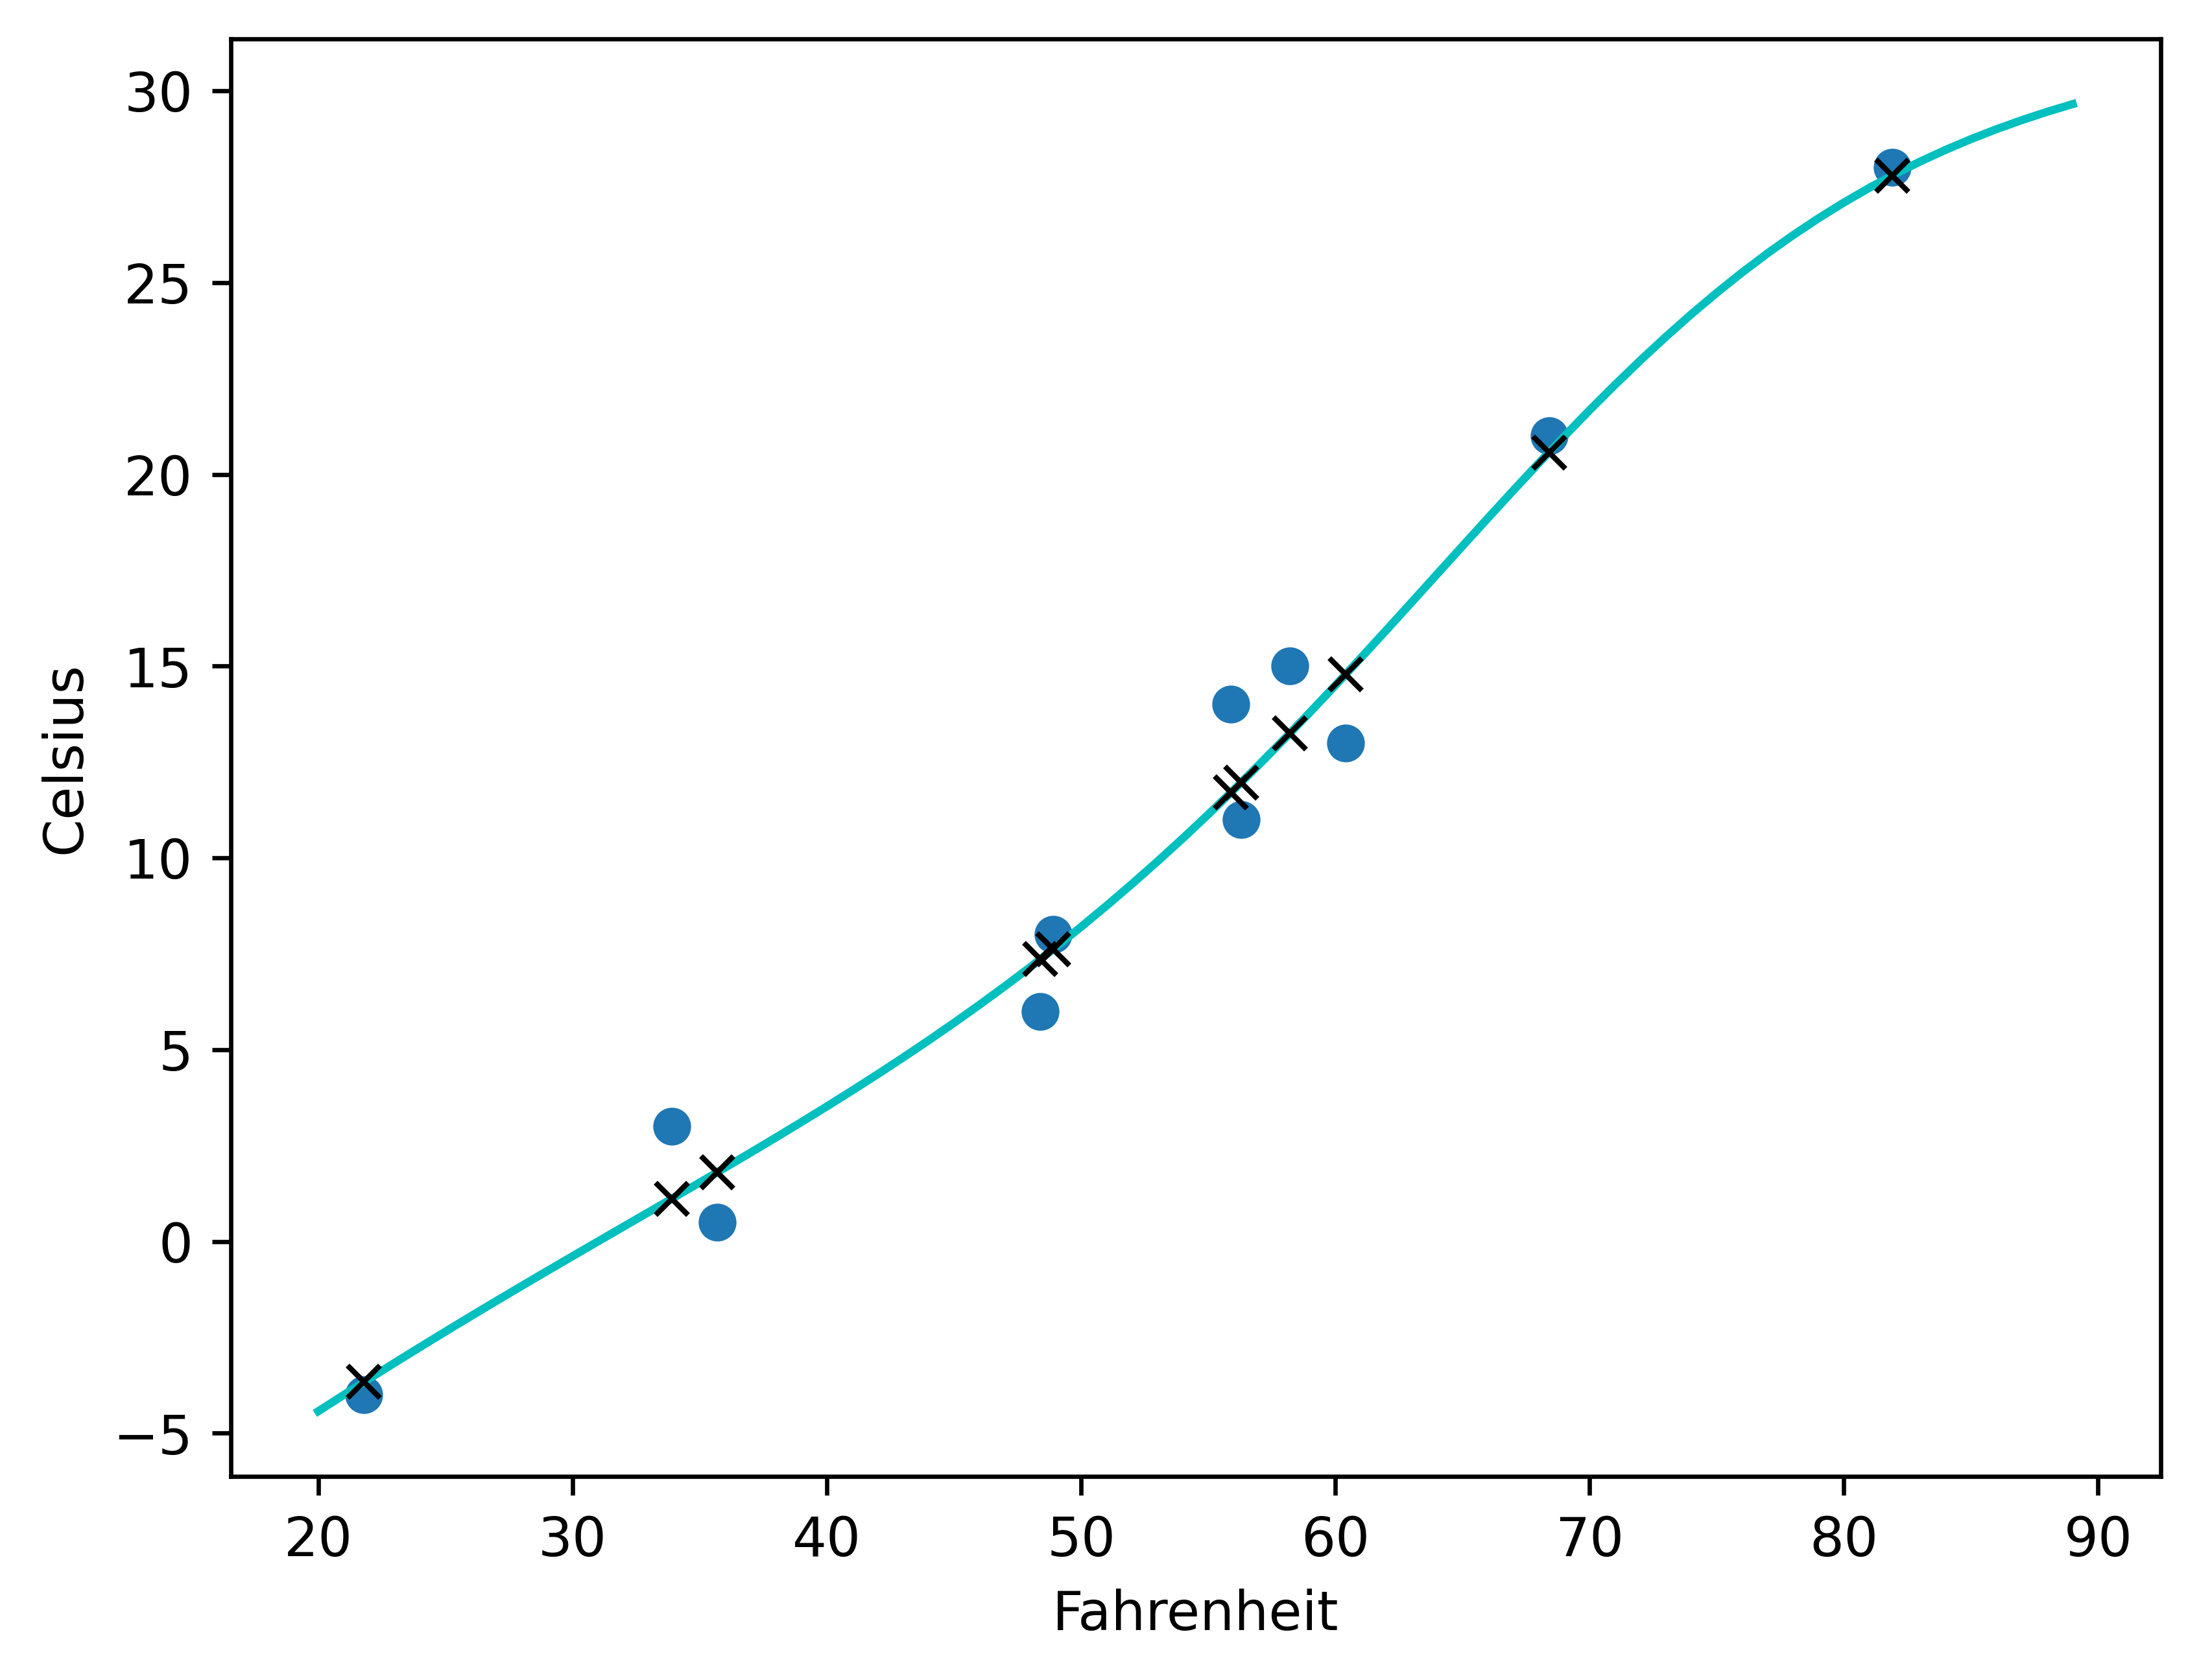

In [23]:
from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')


Epoch 1, Training loss 198.8684, Validation loss 182.5071
Epoch 1000, Training loss 77.1120, Validation loss 10.8555
Epoch 2000, Training loss 56.2855, Validation loss 6.9778
Epoch 3000, Training loss 34.8167, Validation loss 4.1768
Epoch 4000, Training loss 19.6696, Validation loss 2.9003
Epoch 5000, Training loss 11.1643, Validation loss 2.6616


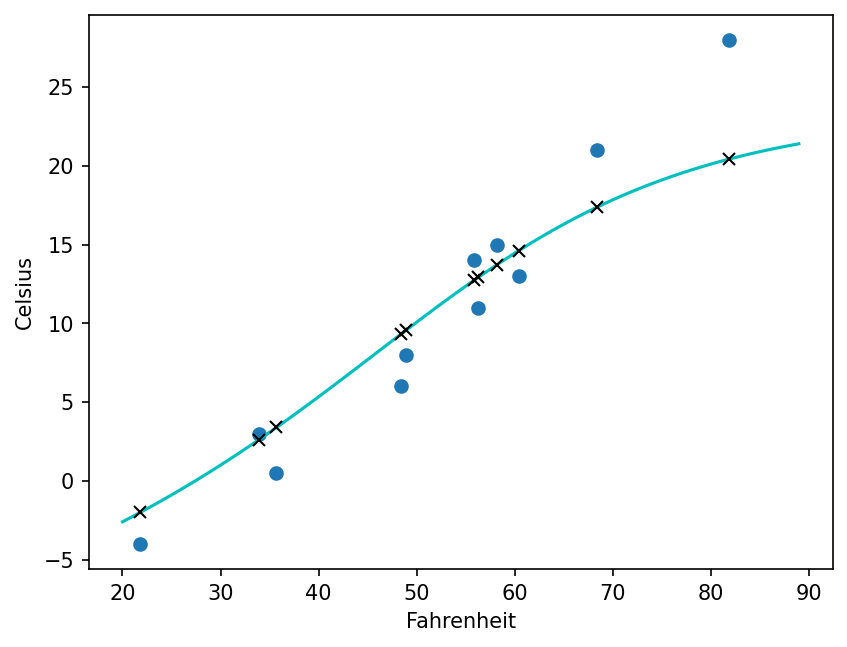

In [24]:
# Exercises here!

neuron_count = 20

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, neuron_count)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(neuron_count, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-4)

training_loop(
    n_epochs = 5000, 
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val, 
    t_c_train = t_c_train,
    t_c_val = t_c_val)

from matplotlib import pyplot as plt

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=150)
plt.xlabel("Fahrenheit")
plt.ylabel("Celsius")
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')
